In [1]:
import networkx as nx
from pulp import *
import numpy as np
from sklearn.cluster import KMeans
from node2vec import Node2Vec
from matplotlib import pyplot as plt
from copy import deepcopy
#seeding

In [2]:
#import graph from text file
G = nx.read_edgelist("Cit-HepTh.txt",create_using=nx.DiGraph(), nodetype = int)
nx.info(G)

/var/folders/b3/rxqhgxhx5sd119rsfyg2df4w0000gn/T/ipykernel_57458/22429923.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G)


'DiGraph with 27770 nodes and 352807 edges'

## Data Preprocessing

In [3]:
### Remove all self refrences
G.remove_edges_from(nx.selfloop_edges(G))

### This is to prune out the unconnected nodes and only use the largest compenent graph
Gprune = deepcopy(G)
Gprune = Gprune.to_undirected()
Gcc = sorted(nx.connected_components(Gprune), key=len, reverse = True)
Glargest = G.subgraph(Gcc[0])
G = Glargest ### reassign the largest component to our graph variable

nx.info(G)

/var/folders/b3/rxqhgxhx5sd119rsfyg2df4w0000gn/T/ipykernel_57458/1463069069.py:11: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G)


'DiGraph with 27400 nodes and 352504 edges'

## Cluster Analysis

In [4]:
#vectorization of the nodes
node2vec = Node2Vec(G, dimensions=2, walk_length=20, num_walks=10,workers=6)
model = node2vec.fit(window=10, min_count=1)
model.wv.save_word2vec_format("embedding.emb")

Computing transition probabilities:   0%|          | 0/27400 [00:00<?, ?it/s]

Generating walks (CPU: 6): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


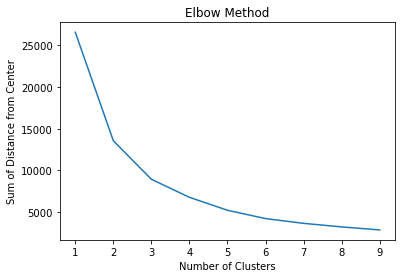

In [5]:
#import data
data = np.loadtxt("embedding.emb", skiprows=1)

#data pre-processing to fit the structure
data =data[data[:,0].argsort()]
data1=data[0:data.shape[0],1:data.shape[1]]

#elbow method to find K
sumdist = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data1)
    #labeling each node to cluster
    labels = kmeans.labels_
    #finding the sum within same cluster
    sumdist[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sumdist.keys()), list(sumdist.values()))
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Distance from Center")
#save file
#plt.savefig("KMeans_Elbow.png")
plt.show()

## Creating Clusters

In [6]:
#we shall choose K = 5 based on the elbow method
np.random.seed(123456789)
k=5
kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data1)
labels = kmeans.labels_
labels_list = labels.tolist()

In [7]:
#set node attribute with the labels
att = {}
nodes_list = list(G.nodes)
for i in range(len(nodes_list)):
    att[nodes_list[i]] = labels_list[i]
nx.set_node_attributes(G,att, name="Cluster")

In [8]:
#dictionary of each nodes in clusters
clusternodes = {}
for i in range(k):
    cluster = []
    for (p, d) in G.nodes(data=True):
        if d["Cluster"] == i:
            cluster.append(p)
    clusternodes[i]=cluster

#create graphs of nodes and edges based on its cluster label
Gcluster = {}
for i in range(0,k):
    Graph = nx.DiGraph()
    for j in clusternodes[i]:
        Graph.add_node(j)
    for (u,v) in G.edges:
        if u in Graph.nodes and v in Graph.nodes:
            Graph.add_edge(u,v)
    Gcluster[i] = Graph

## Betweness Centrality

In [9]:
#calculate betwness centrality for each cluster and find the node with maximum centrality
bccluster = {}
for i in range(k):
    bc = nx.betweenness_centrality(Gcluster[i])
    for key, value in bc.items():
        if bc[key] == max(bc.values()):
            print("For Cluster {}, the max centrality node is {}".format(i,key))
            #assign dictionary for later use
            bccluster[i] = key

For Cluster 0, the max centrality node is 9908142
For Cluster 1, the max centrality node is 9711200
For Cluster 2, the max centrality node is 9912271
For Cluster 3, the max centrality node is 9803194
For Cluster 4, the max centrality node is 9905111


## Depth Search First (DFS)

In [10]:
#finding the node with the highest DFS successors
maxnum = 0
prolific = None
#compare by dividing into clusters for faster computation
for c in range(k):
    for i in range(len(Gcluster[c])):
        l = nx.dfs_successors(Gcluster[c],list(Gcluster[c].nodes)[i])
        if len(l) > maxnum:
            maxnum = len(l)
            prolific = (nodes_list[i],len(l))
print(prolific)

(9812021, 1674)


## Linear Programming

In [11]:
# Cut out all nodes that have less than 10 edges.
from copy import deepcopy
Gcluster_LP = deepcopy(Gcluster)

for i in range(k):
    nodes = Gcluster[i].nodes()
    for node in nodes:
        # drop all nodes that have less then 10 citations.
        if len(Gcluster[i].in_edges(node)) < 10:
            Gcluster_LP[i].remove_node(node)
    #only need an undirected graph to show related topics
    Gcluster_LP[i] = Gcluster_LP[i].to_undirected()
    
    #take only the largest component to remove stragglers
    Gcc = sorted(nx.connected_components(Gcluster_LP[i]), key=len, reverse = True)
    Glargest = Gcluster_LP[i].subgraph(Gcc[0])
    Gcluster_LP[i] = Glargest

In [12]:
def MinimumNodeCover(G):
    ###Function to find the minimum nodes to connect the graph (dominating set)
    
    prob = LpProblem(name="graphs", sense=LpMinimize)
    #Vars
    nodes = pulp.LpVariable.dicts('node',(name for name in G.nodes()),
                                       lowBound=0, upBound=1,
                                       cat='Integer')

   #obj
    prob += lpSum([nodes[i] for i in G.nodes()])  # Sum on the selected nodes

   #cons
    #suboptimal because each non-self edge is counted twice. only need to look at values that are greater
    for j in G.nodes():
        prob += lpSum(nodes[i]*G.has_edge(i,j)+nodes[j] for i in G.nodes()) >= 1
    
    #PULP_CBC_CMD(msg=False) is to remove annoying text introduction of pulp
    prob.solve(PULP_CBC_CMD(msg=False))
    
    # Get the list of selected nodes
    pickednodes = []
    
    for variable in prob.variables():
        if variable.varValue == 1:
            pickednodes.append(variable)
        
    return(pulp.value(prob.objective), pickednodes)



In [13]:
## find the dominating set for each cluster
clustersolution = {}
for i in range(k):
    solnum, sollist = MinimumNodeCover(Gcluster_LP[i])
    clustersolution[i] = {"count": solnum, "list": sollist}

In [14]:
#print answers
for i in range(0,k):
    print(i, ": ", clustersolution[i]["count"])
    ### print papers if there are only 5 nodes in the solution
    if clustersolution[i]["count"] < 5:
        print("Papers in Cluster", i, ":", clustersolution[i]["list"])

0 :  119.0
1 :  60.0
2 :  1.0
Papers in Cluster 2 : [node_10108]
3 :  7.0
4 :  66.0


## Longest Path

In [15]:
#finding outlier paper
#set each cluster edge weight to -1 to fix longest path cycles
for i in range(0,k):
    Gcluster[i] = Gcluster[i].reverse()
    
# calculate the shortest path for each node from the central node, then we can take the largest for each cluster    
outliercluster= {}
for i in range(0,k):
    holder = {}
    
    for node in Gcluster[i].nodes():
        try:
            holder[node] = len(nx.dijkstra_path(Gcluster[i], bccluster[i], node))
        except:
            holder[node] = -1 # shows that there is no path to the central
    # want the node and the distance
    longest = max(holder.values())
    outliercluster[i] = [key for (key, value) in holder.items() if value == longest]
outliercluster

{0: [304073, 304211],
 1: [10009, 11034, 108038, 110091, 202069, 212256, 301092, 304215],
 2: [201178, 210217, 211261, 211271, 211291],
 3: [301090],
 4: [303069]}